In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import shelve
import random
import itertools
import omero

from pandas import Series,DataFrame,read_csv, merge,concat,read_hdf
from omero.gateway import BlitzGateway
from matplotlib.widgets import Slider
from matplotlib import gridspec
from sklearn.externals import joblib
from contextlib import closing

from sklearn import random_projection
import sklearn.neighbors as nn
import sklearn.manifold as man
import sklearn.decomposition as dec
from sklearn.preprocessing import scale,robust_scale
from sklearn.metrics.pairwise import euclidean_distances


%matplotlib nbagg
plt.rcParams['image.cmap']='gray'

#hard coded dirs
dbpath='/home/ubuntu/idr_homes/szleo/features/idr0008-rohn-actinome/screenB/output/'
dataDir='/home/ubuntu/data'
scratchDataDir='/scratch/rohnFeatures'


In [2]:
def getImIDs(plns, wells,fields):
    lids=list()
    try:
        conn = BlitzGateway('demo', 'cambridge', host='orca-3.openmicroscopy.org', port=4064)
        connected = conn.connect()

        for pln,wstr,f in zip(plns,wells,fields):
        
            r=ord(wstr[0:1])-65
            c=int(wstr[1:])-1
            
#            print pln,wstr,f,r,c

            Q='''select well from Well as well 
            left outer join fetch well.wellSamples as ws 
            left outer join fetch ws.image as img 
            where well.plate.name = \'''' + pln+ '\' and well.row='+str(r)+' and well.column='+str(c)

            w=conn.getQueryService().findAllByQuery(Q,None)[0]
            im = w.getWellSample(int(f)-1).getImage()
            lids.append(im.getId().getValue())
    finally:
        conn._closeSession()
    
    return lids

In [3]:
def getMapAnnotationsAsDicts(imids):
    la=list()
    try:
        conn = BlitzGateway('demo', 'cambridge', host='orca-3.openmicroscopy.org', port=4064)
        connected = conn.connect()

        for imid in imids:
            im= conn.getObject("Image",imid)
            a=im.getAnnotation()
            la.append(dict(a.getValue()))
    finally:
        conn._closeSession()
    
    return la

In [4]:
def db2pd(fin):
#from https://gist.github.com/manics/bc003272b038027faf653d576f3c9393

    with closing(shelve.open(fin, "r")) as f:
        values = list(f.itervalues())

    x = values[0]

    header_meta = []
    header_ft = []
    header_ftn = []

    for k in sorted(x.keys()):
        v = x[k]
        if isinstance(v, list):
            header_ft.append(k)
            header_ftn.extend('%s_%02d' % (k, i) for i in xrange(len(v)))
        else:
            header_meta.append(k)

    assert len(header_ft) == 124
    assert len(header_meta) == 11

#    print "Processing %s" % fin
    rows = []
    for vs in values:
        meta = [vs[h] for h in header_meta]
        ft = [vs[h] for h in header_ft]
        r = itertools.chain.from_iterable([meta] + ft)
        rows.append(list(r))

#    print "Creating dataframe %s" % fin
    df = DataFrame(rows, columns=(header_meta + header_ftn))

    return df


In [13]:
def getRohnTile(imid,x,y,w,h,chan=0):
#    plateId,x,y,w,h,ti,tf=422,0,0,200,200,50,150
    try:
        conn = BlitzGateway('demo', 'cambridge', host='orca-3.openmicroscopy.org', port=4064)
        connected = conn.connect()

        im = conn.getObject("Image", imid)
        pix=im.getPrimaryPixels()

        z=0;c=chan;
        tile = (x, y, w, h) 
        plane = pix.getTile(tile=tile)
    finally:
        conn._closeSession()
    
    return plane

In [22]:
def goneFishing(df,qry,s2w,nbrs):
    chan=0
    

#    hook=getRohnTile(imid,x,y,w,h,chan)    
    
    distances, indices = nbrs.kneighbors(qry)
    nnn=len(indices[0])
    d,r=divmod(nnn,4)
               
    w=df.w.iloc[0]
    h=df.h.iloc[0]
    tiles=np.zeros((h,w,nnn))
    for ind,ii in zip(indices[0],range(nnn)):
        try:
            secur=df.series.iloc[ind]
            x=df.x.iloc[ind]
            y=df.y.iloc[ind]
            w=df.w.iloc[ind]
            h=df.h.iloc[ind]
            imindcur=s2w[(s2w.PLATE==pln)&(s2w.SERIES==secur)].imIds.iloc[0]
            tiles[:,:,ii]=getRohnTile(imindcur,x,y,w,h,chan) 
        except:
            continue

    
    plt.figure(figsize=(12,12))

    imc=buildComposite(tiles,d+(1&r),4,smpl=1)
#    plt.figure(figsize=(12,15))
    plt.imshow(imc)
    

In [7]:
def buildComposite(st,n,m,smpl=None):
    #nxm shots from st in a grid, as an image
    nr=st.shape[0]
    nc=st.shape[1]
    if smpl==None:
        smpl=st.shape[2]/(n*m)
    res=np.zeros((nr*n,nc*m))
    for i in range(n):
        for j in range(m):
            try:
                res[i*nr:i*nr+nr,j*nc:j*nc+nc]=st[:,:,(i*m+j)*smpl]
            except:
                break
    return res

## preping data

In [14]:
#metadata: linking omero, features, annotations

s2w=read_csv(os.path.join(dataDir,'series_to_well.tsv'),sep='\t')
lids=getImIDs(s2w.PLATE, s2w.WELL,s2w.FIELD)
s2w['imIds']=lids
la=getMapAnnotationsAsDicts(s2w.imIds)
s2w['annotations']=la
s2w.to_csv(os.path.join(scratchDataDir,'series_to_well_IDAnnotation.tsv'),sep='\t')

In [8]:
s2w=read_csv(os.path.join(scratchDataDir,'series_to_well_IDAnnotation.tsv'),sep='\t')

## All .db to h5

In [ ]:
for pln in s2w.PLATE.unique():
    print pln
    df=DataFrame()
    for s in range(s2w[s2w.PLATE==pln].SERIES.max()):
        if s%100==0:
            print s
        fin=os.path.join(dbpath, pln,'116_86',pln+'_'+str(s)+'_features'+'.db')
        df=concat((df,db2pd(fin)))
    fout=os.path.join(scratchDataDir,pln+'_features'+'.h5')
    df.to_hdf(fout, 'wndcharm', complevel=9, complib='zlib')
    

Plate3_Actinome1
0
100

## DAPI PCA

In [9]:
#load one plate, it's enough for the test 

s2w=read_csv(os.path.join(dataDir,'series_to_well_IDAnnotation.tsv'),sep='\t')
df=read_hdf(os.path.join(dataDir,'Plate10_Actinome1_features.h5'))

In [10]:
#load PCA of DAPI charm features from condentation screen

pca= joblib.load(os.path.join(dataDir,'PCA_4condentationwells.pkl')) 
dfcond=read_hdf(os.path.join(dataDir,'PCA250features_testwells.h5'))

<IPython.core.display.Javascript object>


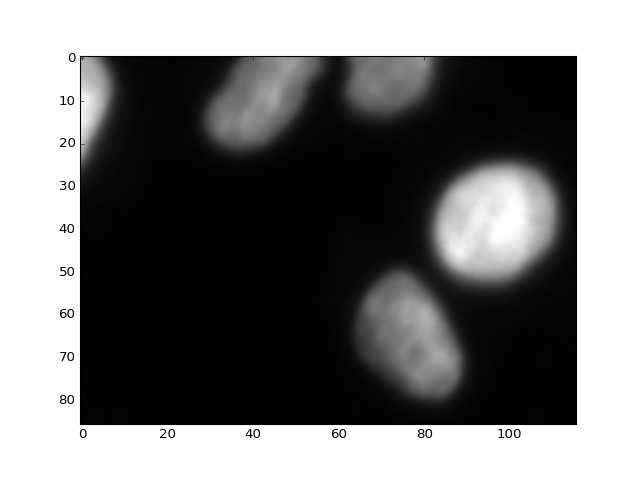

In [20]:
#one tile at random

pln='Plate10_Actinome1'
imid=random.choice(s2w[s2w.PLATE==pln].imIds.unique())
x=random.choice(df.x.unique())
y=random.choice(df.y.unique())
w=116
h=86
im=getRohnTile(imid,x,y,w,h,chan=0)
plt.figure()
plt.imshow(im)

In [11]:
#project Rohn DAPI into PCA axis

dfdapi=df[df.c==0].iloc[:,11:]
dfdapi=scale(dfdapi)
dfdapi=pca.transform(dfdapi)

/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/data.py:167: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


<IPython.core.display.Javascript object>


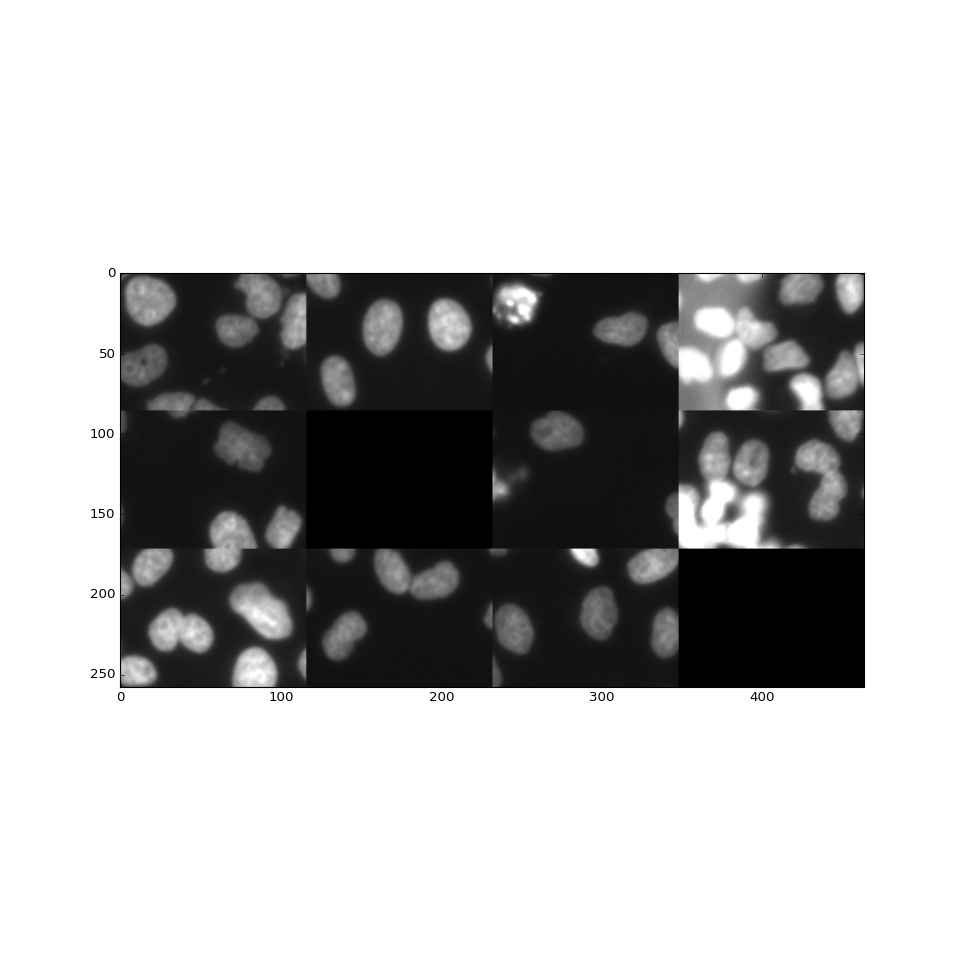

In [23]:
#compute nearest neighbour of Rohn DAPI to a known tile with dividing cells from condensation

nbrs = nn.NearestNeighbors(n_neighbors=12, algorithm='ball_tree').fit(dfdapi) 
plncond,x,y,t='plate1_1_013_5',504,384,220  #division at 220

qry=dfcond[(dfcond.x==x) & (dfcond.y==y) & (dfcond.name==plncond) & (dfcond.t==t)].iloc[:,12:]
goneFishing(df,qry,s2w,nbrs)